In [33]:
import pandas as pd
import random
import time
import math
import matplotlib.pyplot as plt

In [34]:
FILE_QUERIES = '../data/queries_combined/3.csv'
DIR_WORKLOADS = '../docker/workloads/'

In [45]:
# def create_bursty(queries, num_applications, length, offset, delay, burst_interval, burst_intensity, burst_variety, duration_avg, duration_variety, rand_seed=None):
    
#     timeline = pd.DataFrame(columns=['app', 'start', 'query', 'range', 'end'])
    
#     if not rand_seed:
#         rand_seed = abs(int(time.time() * 1000) % (2**32))
#     random.seed(rand_seed)
    
#     for app in range(num_applications):
#         start = delay + offset * app
    
#         # one burst at 0 and then as many as still fit with the right starting interval
#         num_bursts = (length - start) // burst_interval + 1

#         timeline_app = pd.DataFrame(columns=['start', 'query', 'range', 'end'])

#         for burst in range(num_bursts):
#             curr_time = start + burst * burst_interval

#             random_number = random.uniform(-1, 1)
#             deviation = burst_intensity * burst_variety * random_number
#             num_queries = burst_intensity + int(round(deviation))

#             duration_min = duration_avg - (duration_avg * duration_variety)
#             duration_max = duration_avg + (duration_avg * duration_variety)
            
#             # filter the available queries for the appropriate durations and then select random ones from that
#             queries_subset = queries[(queries['duration'] >= (duration_min * 1000)) & (queries['duration'] <= (duration_max * 1000))]

#             # possibly needs some seed here as well
#             random_rows = queries_subset.sample(n=num_queries, replace=True, random_state = rand_seed + (app + 1) * (burst + 1))
            
#             timeline_burst = random_rows[['query', 'range', 'duration']]
#             timeline_burst.rename(columns={'duration': 'end'}, inplace=True)
#             timeline_burst['end'] = timeline_burst['end'] / 1000
#             timeline_burst['end'] = timeline_burst['end'] + curr_time
#             timeline_burst['start'] = curr_time

#             timeline_app = pd.concat([timeline_app, timeline_burst], ignore_index=True)
            
#         timeline_app['app'] = app
#         timeline = pd.concat([timeline, timeline_app])

#     return timeline

In [58]:
def create_bursty(queries, num_apps:int, burst_count:int, burst_interval, query_duration, burst_intensity:int,
                   burst_interval_var=0.0, query_duration_var=5.0, burst_intensity_var=0, 
                   query_start_var=0.0, initial_delay=0.0, rand_seed=None):
    """
    Generate a bursty workload timeline based on the given parameters.

    Parameters
    ----------
    queries : dataframe with columns [query, 'range', 'duration']
        A DataFrame containing all available queries including expected execution durations
    num_apps : int
        Number of apps.
    burst_count : int
        Number of bursts per app.
    burst_interval : int or float
        Time interval between bursts (in seconds)
    query_duration : int or float
        Desired duration of queries (in seconds)
    burst_intensity : int
        Number of queries per burst.
    burst_interval_var : float
        Variability of burst intervals (in seconds)
    query_duration_var : float
        Variability of query durations (in seconds)
    burst_intensity_var : int
        Variability of burst intensity.
    query_start_var : float
        Possible delay of query start times (in seconds)
    initial_delay : float
        Initial delay of workload.
    rand_seed : int
        Seed for random number gen.
    """
    
    timeline = pd.DataFrame(columns=['app', 'start', 'query', 'range', 'end'])

    if not rand_seed:
        rand_seed = int(time.time() * 1000) % (2**32)
    print(f'Bursty for {num_apps} apps with seed: {rand_seed}')
    random.seed(rand_seed)
    
    duration_min = query_duration - (query_duration_var)
    duration_max = query_duration + (query_duration_var)
    queries_subset = queries[(queries['duration'] >= (duration_min * 1000)) & (queries['duration'] <= (duration_max * 1000))]
    
    for app in range(num_apps):
        start_time = initial_delay + burst_interval * app

        timeline_app = pd.DataFrame(columns=['start', 'query', 'range', 'end'])

        for burst in range(burst_count):
            burst_start_deviation = random.uniform(-1, 1) * burst_interval_var
            curr_time = start_time + burst * burst_interval * num_apps + burst_start_deviation

            burst_intensity_deviation = random.uniform(-1, 1) * burst_intensity_var
            num_queries = burst_intensity + int(round(burst_intensity_deviation))
            # possibly needs some seed here as well
            rand_seed_burst = (rand_seed + (app + 1) * (burst + 1)) % (2**32)
            random_queries = queries_subset.sample(n=num_queries, replace=True, random_state=rand_seed_burst)
            
            timeline_burst = random_queries[['query', 'range', 'duration']]
            timeline_burst['start'] = curr_time
            timeline_burst['start'] = timeline_burst['start'].apply(lambda x: x + random.uniform(0, query_start_var))
            timeline_burst.rename(columns={'duration': 'end'}, inplace=True)
            timeline_burst['end'] = timeline_burst['end'] / 1000 + timeline_burst['start']

            timeline_app = pd.concat([timeline_app, timeline_burst], ignore_index=True)
            
        timeline_app['app'] = app
        timeline = pd.concat([timeline, timeline_app])

    return timeline

In [56]:
def create_random(queries, num_apps:int, duration, query_duration_min, query_duration_max, intensity, intensity_var=0, initial_delay=0, rand_seed=None):
    timeline = pd.DataFrame(columns=['app', 'start', 'query', 'range', 'end'])

    if not rand_seed:
        rand_seed = int(time.time() * 1000) % (2**32)
    print(f'Random for {num_apps} apps with seed: {rand_seed}')
    random.seed(rand_seed)

    queries_subset = queries[(queries['duration'] >= (query_duration_min * 1000)) & (queries['duration'] <= (query_duration_max * 1000))]
    end_time = duration + initial_delay

    for app in range(num_apps):

        num_queries = int(round((intensity + int(round(random.uniform(-1, 1) * intensity_var))) * (duration / 60)))
        rand_seed_app = (rand_seed * (app + 1)) % (2 ** 32)
        random_queries = queries_subset.sample(n=num_queries, replace=True, random_state=rand_seed_app)
        timeline_app = random_queries[['query', 'range', 'duration']]
        timeline_app['start'] = [random.uniform(initial_delay, end_time) for _ in range(num_queries)]
        timeline_app.rename(columns={'duration': 'end'}, inplace=True)
        timeline_app['end'] = timeline_app['end'] / 1000 + timeline_app['start']
        timeline_app['app'] = app
        timeline = pd.concat([timeline, timeline_app], ignore_index=True)

    return timeline

In [38]:
def get_load_changes(timeline):
    start_times = [(time, +1) for time in timeline['start']]
    end_times = [(int(math.ceil(time)), -1) for time in timeline['end']]

    return sorted(start_times + end_times)

def get_load_timeline(load_changes):
    load = 0
    load_timeline = []
    if len(load_changes) > 0:
        last_time = 0
        for time, delta in load_changes:
            if (time != last_time):
                load_timeline.append((last_time, load))
                if (time - last_time > 1):
                    load_timeline.append((time - 1, load))
                last_time = time
            load += delta
        load_timeline.append((last_time, load))
    # print(load_timeline)
    return load_timeline


def plot_timeline(timeline: pd.DataFrame):

    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel(f'Time in Seconds')
    ax.set_ylabel('Active Queries')

    for app in timeline['app'].unique():

        load_timeline = get_load_timeline(get_load_changes(timeline[timeline['app'] == app]))
        df_load = pd.DataFrame(load_timeline, columns=['time', 'activeQueries'])
        df_load = df_load.set_index(pd.to_datetime(df_load['time'], unit='s'))

        # possibly do something to make all timelines end at the same point (some currently end earlier)

        ax.plot(df_load['time'], df_load['activeQueries'], label=f'App {app}')
    
    ax.legend()
    return

In [25]:
def save_timeline(timeline: pd.DataFrame, dir, filename):
    timeline = timeline.sort_values(['start', 'app'])
    timeline[['app', 'start', 'query', 'range']].to_csv(f'{dir}/{filename}.csv', header=False, index=False)

In [39]:
def gen_plot_and_save_timelines(generator, num_apps:list, filename, dir=DIR_WORKLOADS):
    timelines = [(n, generator(n))
    for n in num_apps]

    for n, timeline in timelines:
        plot_timeline(timeline)
        save_timeline(timeline, dir, f'{filename}_{n}')

In [16]:
queries = pd.read_csv(FILE_QUERIES)
display(queries)

,query,range,duration
0,q1,d_date = cast('2000-04-30' as date),5809
1,q1,d_year = 1999 and d_moy = 8,5906
2,q1,d_date between cast('2000-08-23' as date) and ...,6240
3,q1,d_year = 2000 and d_moy = 1,7800
4,q1,d_year = 2000 and (d_moy between 6 and 8),9272
...,...,...,...
86,q95,d_year = 2000 and d_moy = 1,461744
87,q95,d_year = 2000 and d_moy between 1 and 3,463983
88,q95,d_moy = 11,464519
89,q95,d_year = 2000 and d_moy between 1 and 9,465980


In [9]:
test = create_bursty(
    queries, 
    num_applications=3, 
    length=100,
    offset=15,
    delay=1,
    burst_interval=45,
    burst_intensity=5,
    burst_variety=.3,
    duration_avg=10,
    duration_variety=.6,
    rand_seed=100
    )

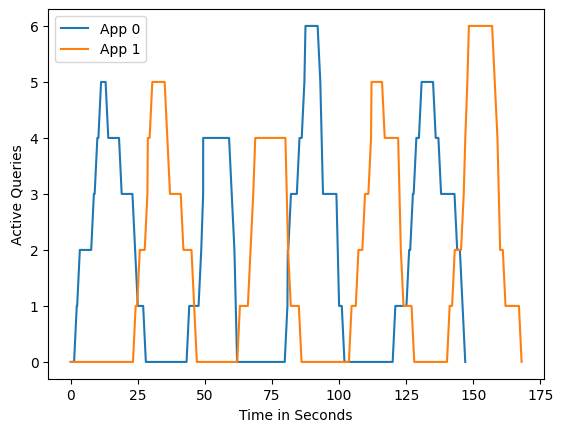

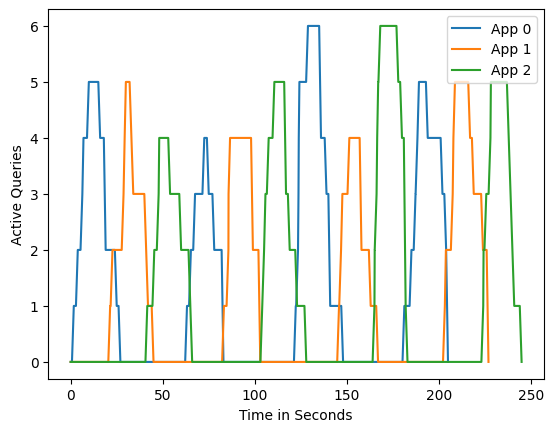

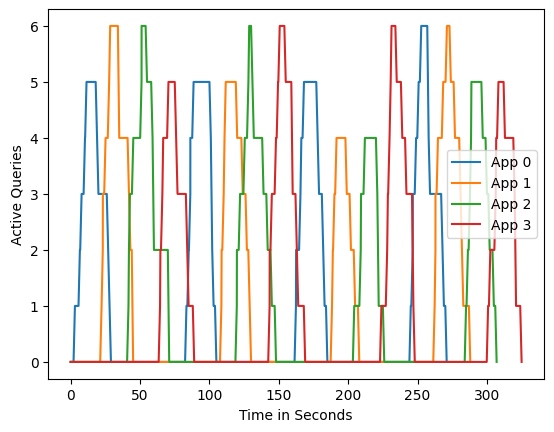

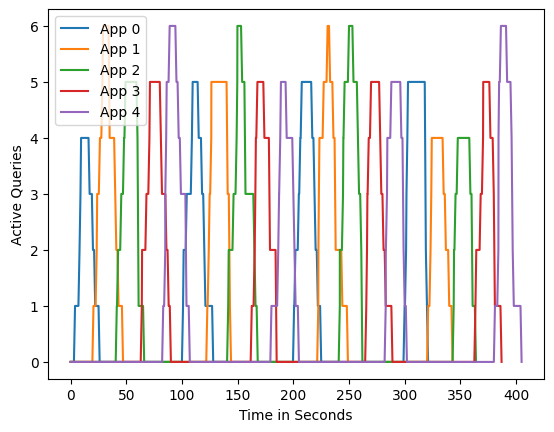

In [40]:
gen_plot_and_save_timelines(
    lambda n: create_bursty(
        queries, 
        num_apps=n,
        burst_count=4,
        burst_interval=20,
        query_duration=15,
        burst_intensity=5,
        burst_interval_var=2,
        query_duration_var=5,
        burst_intensity_var=1,
        query_start_var=10,
        initial_delay=1
    ),
    range(2, 6), 'bursty')

Random: 2 apps with seed: 3202908322
Random: 3 apps with seed: 3202908337
Random: 4 apps with seed: 3202908348
Random: 5 apps with seed: 3202908360


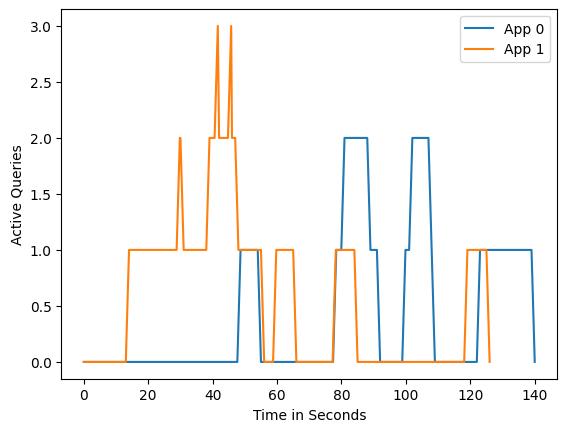

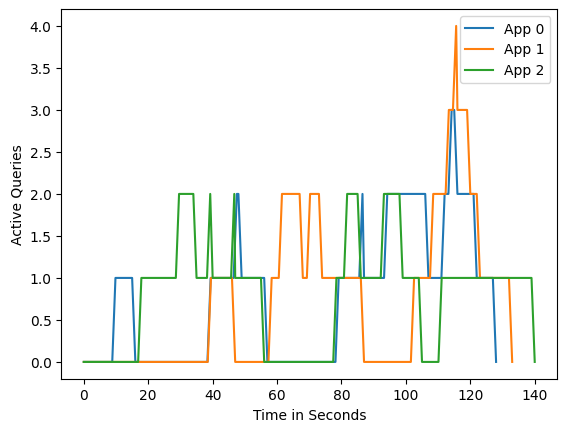

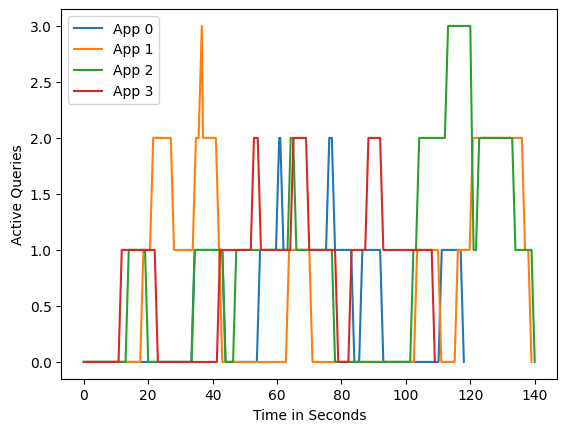

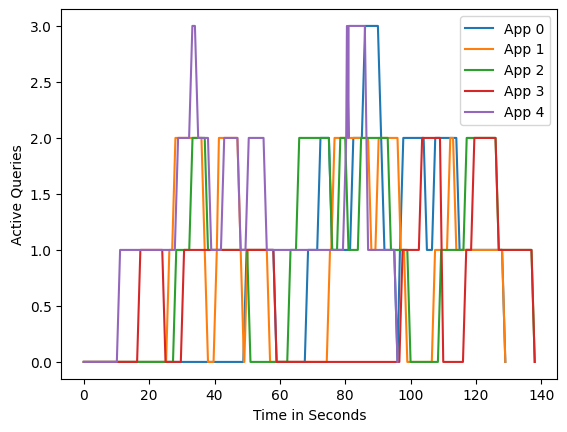

In [57]:
gen_plot_and_save_timelines(
    lambda n: create_random(
        queries, 
        num_apps=n,
        duration=120,
        query_duration_min=5,
        query_duration_max=30,
        intensity=4,
        intensity_var=1,
        initial_delay=5
    ),
    range(2, 6), 'random_medium')